In [1]:
# General

from functools import reduce

# Data Analysis

import pandas as pd
import numpy as np

# Visualization

import matplotlib.pyplot as plt
import geopandas as gpd


# WBAPI

import wbgapi as wb

# Data Processing

from sklearn.preprocessing import MinMaxScaler


In [9]:
africa_women = wb.data.DataFrame('SG.GEN.PARL.ZS', wb.region.members('AFR'), mrv=1)


In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world.query('continent == "Africa"')[['iso_a3', 'geometry']]


In [12]:
merge_africa = africa.merge(africa_women, left_on = 'iso_a3', right_index = True)

In [15]:
merge_africa.columns

Index(['iso_a3', 'geometry', 'SG.GEN.PARL.ZS'], dtype='object')

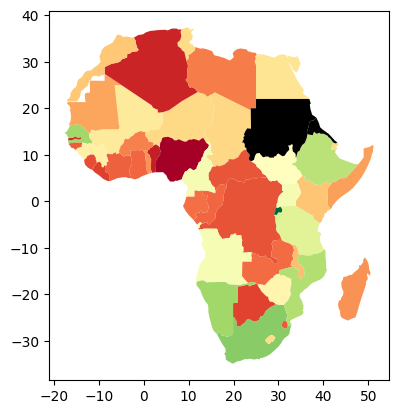

In [17]:
merge_africa.plot(column='SG.GEN.PARL.ZS', cmap='RdYlGn', missing_kwds={'color': 'black'})
plt.show()


In [11]:
def indicator_to_df(query, specify = False):
    if specify:
        return pd.DataFrame(wb.series.Series(q= query)).reset_index().iloc[specify]
    return pd.DataFrame(wb.series.Series(q= query)).reset_index()

def merge_indicator_df(ind_df_list):
    return pd.concat(ind_df_list).reset_index(drop=True)

def get_data_from_merged_index_df(all_dim_indicators):
    
    wb.db = 2
    df2 = wb.data.DataFrame(list(all_dim_indicators['index']), wb.region.members('AFR'), mrv=1)
    wb.db = 3
    df3 = wb.data.DataFrame(list(all_dim_indicators['index']), wb.region.members('AFR'), mrv=1)

    country_index = df2.index
    
    merged_df = df2.merge(df3)
    
    merged_df.index = country_index
    
    return merged_df

In [21]:
wb.db = 2

ind_g6 = indicator_to_df('Proportion of seats held by women')
# ind_g6 = wb.data.DataFrame(ind_g6['index'], mrv=1)

# ind_g6.notna().mean()
#ind_g6[ind_g6.columns[-1]].notna().mean()
# int(ind_g6.columns[-1][2:])

In [22]:
ind_g6 = wb.data.DataFrame(ind_g6['index'], mrv=1)

In [27]:
ind_g6.columns = ['Final Value']

In [28]:
ind_g6

,Final Value
economy,
ABW,NaN
AFE,30.523627
AFG,NaN
AFW,19.182782
AGO,33.636364
...,...
XKX,NaN
YEM,0.000000
ZAF,46.500000


In [42]:
def wb_data_completer(indicator, coverage_threshold = 0.85, years_to_check = 10, database = None, specify = False):
    
    def indicator_to_df(query, specify = False):
        
        # Function to get indicator code
        
        if specify:
            return pd.DataFrame(wb.series.Series(q= query)).reset_index().iloc[specify]
        return pd.DataFrame(wb.series.Series(q= query)).reset_index()
    
    def fetch_data_and_calculate_completeness(database_number):
        
        # Checks coverage of data
        
        wb.db = database_number
        db_ind = indicator_to_df(indicator)
        
        if len(db_ind) == 0:  # If no data is found for this database
            return 0  # Completeness is 0%
        return float(wb.data.DataFrame(db_ind['index'], mrv=1).notna().mean())
    
    # Check which database to use if not specified
    
    if database is None:
        
        db2_complete = fetch_data_and_calculate_completeness(2)
        db3_complete = fetch_data_and_calculate_completeness(3)
        
        database = 2 if db2_complete >= db3_complete or db3_complete == 0 else 3
    
    # Check coverage of most recent year
    
    wb.db = database
    coverage_complete = fetch_data_and_calculate_completeness(database)
    final_ind = indicator_to_df(indicator)
        
    # Return mrv = 1 if already passing data threshold
    
    if coverage_complete > coverage_threshold:
        print(f"""Data for '{indicator}' found in WB Database {database}. Returning data for the most recent year. 
        Coverage = {round(coverage_complete, 4)*100}%, greater than selected threshold of {round(coverage_threshold, 4)*100}%.""")
        final_ind = wb.data.DataFrame(final_ind['index'], mrv=1)
        final_ind.columns = ['Final Value']
        
        return final_ind
    
    # Otherwise go back number of years specified
    
    else:
        
        print(f"""Data for '{indicator}' does not meet the coverage threshold of {coverage_threshold*100}% in WB Database {database}.
        Extracting data from previous years.""")
        
        # Get Data
        
        
        multiyear_df = wb.data.DataFrame(final_ind['index'], mrv=years_to_check)
        
        # Loop through DF in reverse order
        
        current_year = int(multiyear_df.columns[-1][2:])
        all_years = list(range(current_year, current_year - years_to_check, -1)) 
        
        for i, year in enumerate(all_years):
            year_column = f'YR{year}'
            
            # Skip years that don't have a corresponding column in the DataFrame
            
            if year_column not in multiyear_df.columns:
                continue 
                
            # For the first year, initialize 'Final_Value' with its values
            
            if i == 0:
                multiyear_df['Final_Value'] = multiyear_df[year_column]
                
            # Fill missing values in 'Final_Value' with the current year's data
 
            else:
                multiyear_df['Final_Value'] = multiyear_df['Final_Value'].fillna(multiyear_df[year_column])
            
            # Check data completeness for 'Final_Value' after potential filling
            
            data_coverage = multiyear_df['Final_Value'].notna().mean()
            if data_coverage >= coverage_threshold:
                print(f"""Achieved {round(data_coverage,4)*100}% data coverage by going back to data from {year},
                exceeding minimum threshold of {coverage_threshold*100}%. Returning this dataframe.""")
                break
                
        # Return Final DF
                
        if data_coverage < coverage_threshold:
            
            print(f"""Data coverage at {round(data_coverage,4)*100}% after going back {years_to_check} years.
            Failed to exceed minimum threshold of {coverage_threshold*100}%. Returning best dataframe anyway""")
            
            
        return multiyear_df[['Final_Value']]


In [46]:
df = wb_data_completer('Proportion of seats held by women', coverage_threshold=0.9, years_to_check=5)

/Users/samueldrewes/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/wbgapi/__init__.py:620: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series({row[key]: row[value] for row in data}, name=name)


Data for 'Proportion of seats held by women' does not meet the coverage threshold of 90.0% in WB Database 2.
        Extracting data from previous years.
Achieved 90.23% data coverage by going back to data from 2019,
                exceeding minimum threshold of 90.0%. Returning this dataframe.


In [47]:
df.notna().mean()

Final_Value    0.902256
dtype: float64

In [21]:
int(wb.data.DataFrame(indicator_to_df('Proportion of seats held by women')['index'][0], mrv=10).columns[-1][2:])

2022

In [10]:
acled_df = pd.read_csv('../data/acled/2023_all_data.csv')

In [19]:
grouped_acled = acled_df.groupby(by = 'country').sum()[['fatalities']]

In [3]:
geodata_df=pd.read_csv('../data/geodata.csv')

In [20]:
grouped_acled

,fatalities
country,
Afghanistan,1124
Albania,1
Algeria,14
Andorra,0
Angola,90
...,...
Wallis and Futuna,0
Yemen,3234
Zambia,15


In [23]:
merged_geo = geodata_df.merge(grouped_acled, left_on='country_border_name', right_index=True, how = 'left')

In [25]:
b

,fatalities
country_name,
Afghanistan,2349.0
Aland Islands,0.0
Albania,164.0
Algeria,5615.0
American Samoa,0.0
...,...
Wallis and Futuna,0.0
Western Sahara,61.0
Yemen,193.0


In [39]:
refugee_df = pd.read_csv('../data/population.csv')

In [42]:
refugee_df.columns

Index(['Year', 'Country of origin', 'Country of origin (ISO)',
       'Country of asylum', 'Country of asylum (ISO)',
       'Refugees under UNHCR's mandate', 'Asylum-seekers',
       'Other people in need of international protection'],
      dtype='object')

In [43]:
refugee_df.set_index("Country of asylum (ISO)")[["Refugees under UNHCR's mandate"]]

,Refugees under UNHCR's mandate
Country of asylum (ISO),
USA,363059
ALB,2676
EGY,294632
ARG,4094
ARM,34634
...,...
TCA,7
KHM,24
ABW,0
